In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax

from nnp_functions.pf_vehicle import PFVehicle
from nnp_functions.particle_filter import ParticleFilter
from nnp_functions.neural_networks import t_FeedForwardNetwork



In [2]:
TAU = 1 / (256 * 8 * 60)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4
RHO = -0.5

## Stoch Vol Experiments State Space Functions

In [3]:
def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = last_val + TAU * KAPPA * (X_BAR - last_val)
    std = jnp.sqrt(TAU) * SIGMA_SIGMA
    next_val = noise * std + means
    return next_val

def f_sample_fn(subkey, particles, Y_array, idt):
    return f_from_noise(particles, jax.random.normal(subkey, len(particles)))
    

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = -0.5 * TAU * jnp.exp(2 * all_particles)
    y_stds = jnp.sqrt(TAU) * jnp.exp(all_particles)
    
    return total_noise * y_stds + y_means

In [4]:
def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)  # Mean reversion
    f_std = jnp.sqrt(TAU) * SIGMA_SIGMA  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    std = jnp.sqrt(TAU) * jnp.exp(prev_particle)  # full variance
    mean = -0.5 * std**2  # expected mean
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))


## Functions for heavy tailed distribution. 

In [5]:
def t_model_sample_from_inputs(model, subkey, inputs):
    means, stds, deg_freedom = model(inputs)
    return jax.random.t(subkey, df=deg_freedom, shape=means.shape) * stds + means

def t_model_weight_from_inputs(model, particles, inputs):
    means, stds, deg_freedom = model(inputs)
    adjusted_particles = (particles - means) / stds
    return jax.scipy.stats.t.logpdf(adjusted_particles, loc=0, scale=1, df=deg_freedom)

In [6]:

TRAIN_KEY = jax.random.key(112)
DATA_KEY = jax.random.key(72)
EVAL_KEY = jax.random.key(80)
INIT_PARTICLE_KEY = jax.random.key(16)

In [7]:
stoch_vol_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)
stoch_vol_vehicle.model_sample_from_inputs = t_model_sample_from_inputs
stoch_vol_vehicle.model_weight_from_inputs = t_model_weight_from_inputs

stoch_bootstrap_pf = ParticleFilter(f_sample_fn, g_likelihood_single)


# Begin Experiment


Generating 1000 runs of data with 5000 timesteps each...

Training model 1/4: n_layers=1, hidden_dim=1


  0%|          | 0/500 [00:00<?, ?it/s]

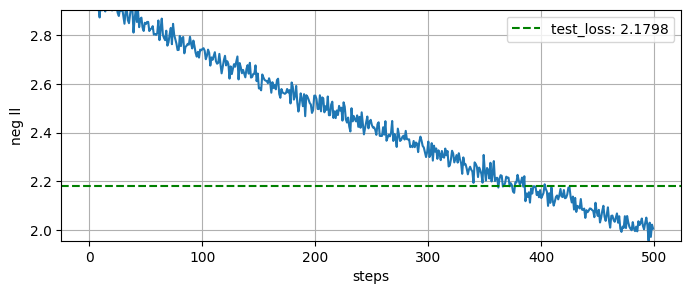


Training model 2/4: n_layers=1, hidden_dim=4


  0%|          | 0/500 [00:00<?, ?it/s]

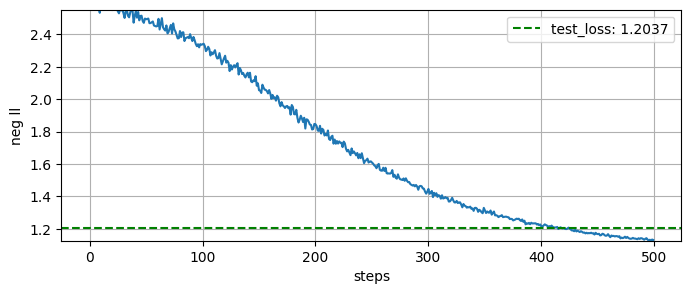


Training model 3/4: n_layers=1, hidden_dim=8


  0%|          | 0/500 [00:00<?, ?it/s]

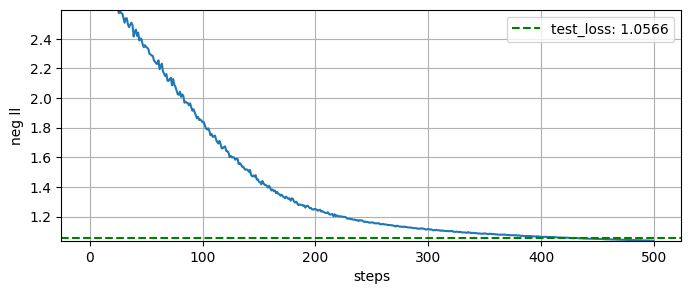


Training model 4/4: n_layers=1, hidden_dim=16


  0%|          | 0/500 [00:00<?, ?it/s]

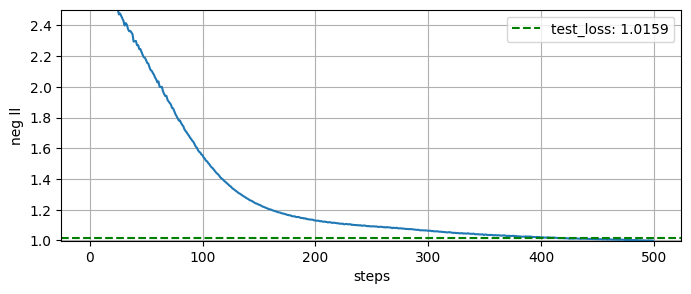

In [16]:
# Loss functions. 

def t_loss(model, inputs, z_i):
    log_likelihood = jax.vmap(t_model_weight_from_inputs, in_axes=(None, 0, 0))(model, z_i, inputs)
    return -jnp.mean(log_likelihood)

def loss(model, inputs, z_i):
    log_likelihood = jax.vmap(PFVehicle.model_weight_from_inputs, in_axes=(None, 0, 0))(model, z_i, inputs)
    return -jnp.mean(log_likelihood)

# Generate test data for evaluation

N_RUNS = 1000
N_TIMESTEPS = 5000

DATA_KEY = jax.random.key(65)
EVAL_KEY = jax.random.key(56)

print(f"Generating {N_RUNS} runs of data with {N_TIMESTEPS} timesteps each...")
test_input_batches, test_target_batches = stoch_vol_vehicle.generate_training_data(
    DATA_KEY, 
    N_RUNS,
    N_TIMESTEPS,
    X_BAR
)

test_inputs = jnp.vstack(test_input_batches)
test_targets = jnp.hstack(test_target_batches)


# Define model sizes to try: list of (n_layers, hidden_dim)
model_sizes = [
    (1, 1),
    (1, 4),
    (1, 8),
    (1, 16),
]

trained_models_evals = {}
for i, (n_layers, hidden_dim) in enumerate(model_sizes):
    print(f"\nTraining model {i+1}/{len(model_sizes)}: n_layers={n_layers}, hidden_dim={hidden_dim}")
    model_key = jax.random.key(100 + i)
    model = t_FeedForwardNetwork(n_layers, hidden_dim, model_key)
    stoch_vol_vehicle.train_model(
        TRAIN_KEY, 
        model,
        1000, 
        learning_rate=1e-3,
        steps = 500, 
        X_bar = X_BAR,
    )

    model_eval = t_loss(stoch_vol_vehicle.unvectorized_model, test_inputs, test_targets)
    trained_models_evals[(n_layers, hidden_dim)] = model_eval


In [17]:
# Getting the bootstrap result. 
def transition_model(input):
    last_x, y = input
    mean = last_x + TAU * KAPPA * (X_BAR - last_x)
    scale = jnp.sqrt(TAU) * SIGMA_SIGMA
    return mean, scale

boot_eval = loss(transition_model, test_inputs, test_targets)


print(trained_models_evals)
print(boot_eval)

{(1, 1): Array(2.027081, dtype=float32), (1, 4): Array(1.128822, dtype=float32), (1, 8): Array(1.0356423, dtype=float32), (1, 16): Array(0.9979256, dtype=float32)}
-2.584716


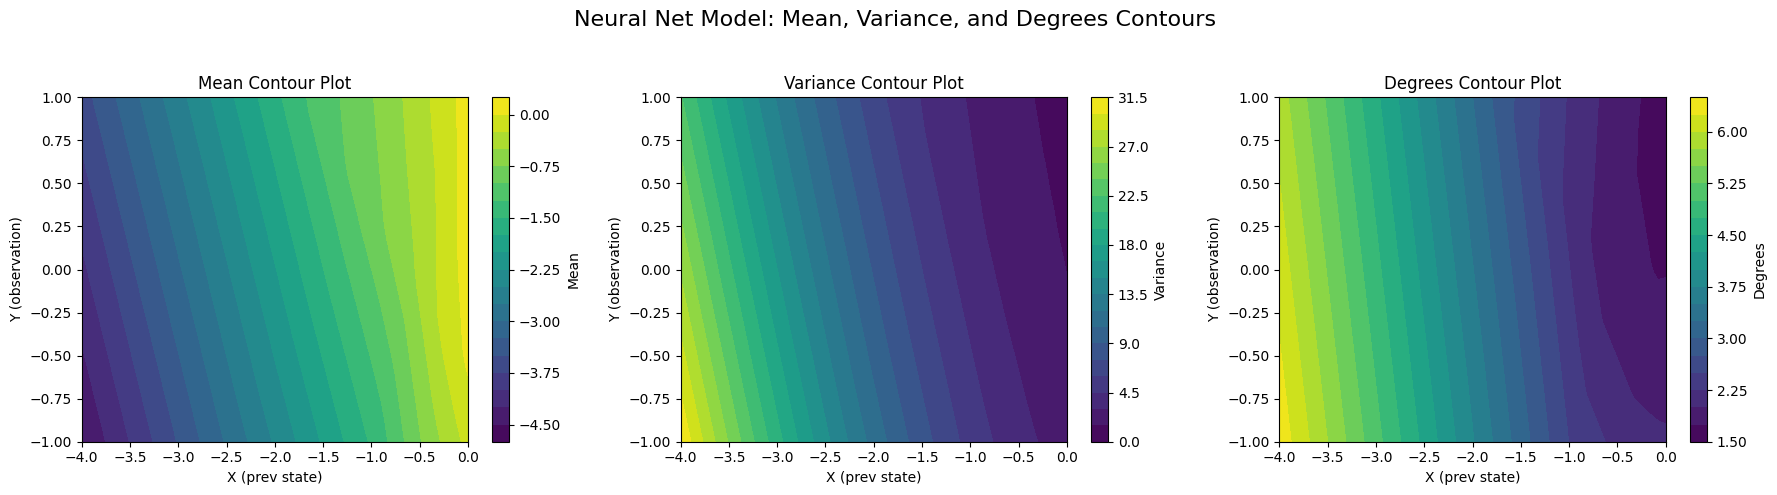

In [18]:
# test that we have loaded the model correctly#
import matplotlib.pyplot as plt
import numpy as np

# Second figure: Contour plots
x_range = (-4, 0)
y_range = (-1, 1)
N_steps = 50  # Increased for smoother contours

x_lin_space = np.linspace(x_range[0], x_range[1], N_steps)
y_lin_space = np.linspace(y_range[0], y_range[1], N_steps)

# Create meshgrid of coordinates
xx, yy = np.meshgrid(x_lin_space, y_lin_space, indexing='ij')

# Stack coordinates into a single array of shape (N_steps, N_steps, 2)
coords = jnp.stack([xx, yy], axis=-1)

# Get predictions from model
means, stds, deg = jnp.array(jax.lax.map(stoch_vol_vehicle.trained_model, coords))

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Neural Net Model: Mean, Variance, and Degrees Contours', fontsize=16)

# Plot mean contour
contour_mean = axes[0].contourf(xx, yy, means, levels=20, cmap='viridis')
cbar_mean = fig.colorbar(contour_mean, ax=axes[0], label='Mean')
axes[0].set_title('Mean Contour Plot')
axes[0].set_xlabel('X (prev state)')
axes[0].set_ylabel('Y (observation)')

# Plot variance contour
contour_var = axes[1].contourf(xx, yy, stds**2, levels=20, cmap='viridis')
cbar_var = fig.colorbar(contour_var, ax=axes[1], label='Variance')
axes[1].set_title('Variance Contour Plot')
axes[1].set_xlabel('X (prev state)')
axes[1].set_ylabel('Y (observation)')

# Plot degrees contour
contour_deg = axes[2].contourf(xx, yy, deg, levels=20, cmap='viridis')
cbar_deg = fig.colorbar(contour_deg, ax=axes[2], label='Degrees')
axes[2].set_title('Degrees Contour Plot')
axes[2].set_xlabel('X (prev state)')
axes[2].set_ylabel('Y (observation)')

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


Generating 1 runs of data with 5000 timesteps each...
Data generation complete.
x_vals shape: (1, 5000), y_vals shape: (1, 5000)
Initial particles and log weights prepared. Shape: (2500,)
Running NN particle filter simulations...
NN particle filter simulations complete.
Running bootstrap particle filter simulations...
Bootstrap particle filter simulations complete.


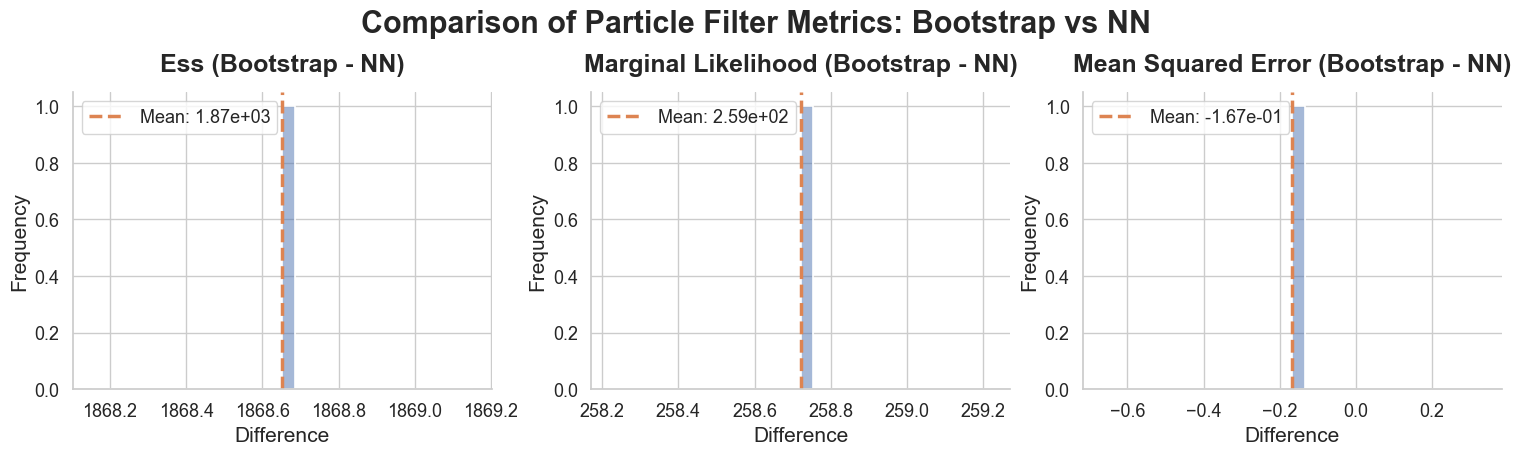

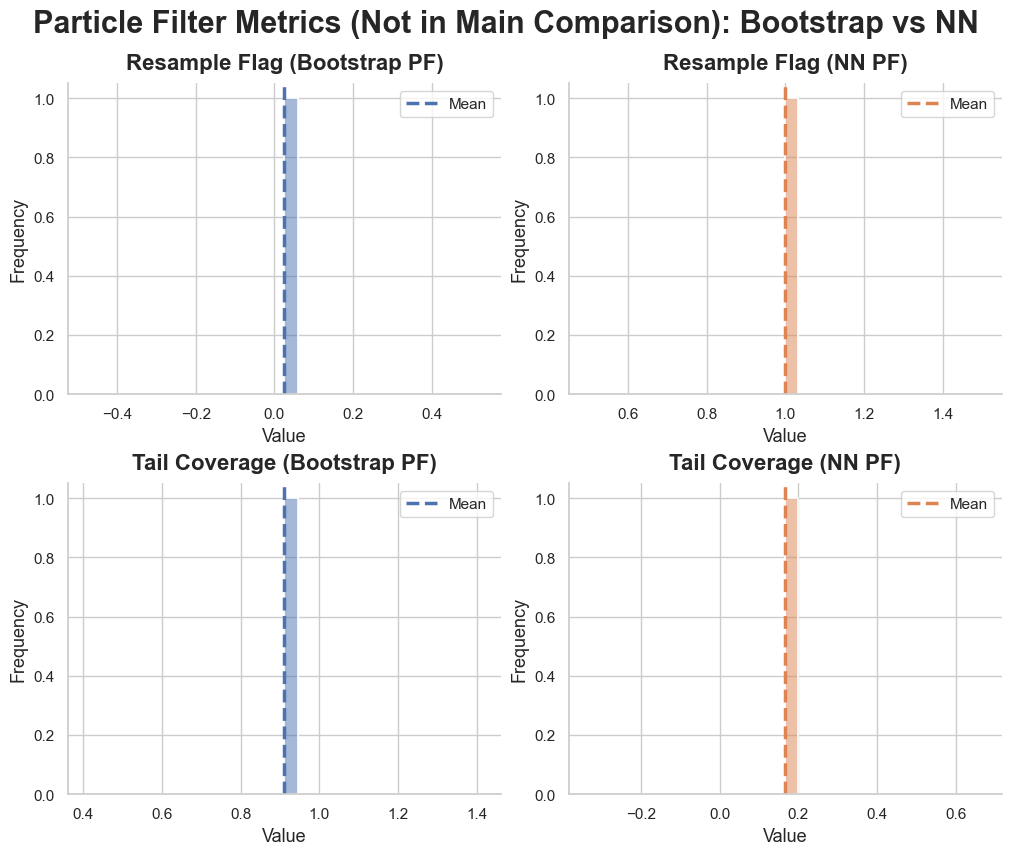

In [20]:
N_RUNS = 1
N_TIMESTEPS = 5000
N_PARTICLES = 2500

DATA_KEY = jax.random.key(65)
EVAL_KEY = jax.random.key(56)

print(f"Generating {N_RUNS} runs of data with {N_TIMESTEPS} timesteps each...")
# 1. Use the stochastic volatility vehicle to generate batched data 

x_vals, y_vals = stoch_vol_vehicle.generate_data(
    DATA_KEY, 
    N_RUNS,
    N_TIMESTEPS,
    X_BAR
)
print("Data generation complete.")
print(f"x_vals shape: {x_vals.shape}, y_vals shape: {y_vals.shape}")

INIT_PARTICLE_KEY = jax.random.key(16)
initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (N_PARTICLES,)) * 0.1 + X_BAR
initial_log_weights = jnp.zeros(N_PARTICLES) - jnp.log(N_PARTICLES)
print(f"Initial particles and log weights prepared. Shape: {initial_particles.shape}")

# 2. Use vmap to get the results for both particle filters. 
a_key, b_key = jax.random.split(EVAL_KEY, 2)

print("Running NN particle filter simulations...")
nn_particle_filter = stoch_vol_vehicle.build_NN_particle_filter(N_PARTICLES = N_PARTICLES)
_, _, nn_diagnostics = jax.vmap(nn_particle_filter.simulate, in_axes=(0, None, None, 0, 0))(
    jax.random.split(b_key, N_RUNS),
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)
print("NN particle filter simulations complete.")

print("Running bootstrap particle filter simulations...")
_, _, bootstrap_diagnostics = jax.vmap(stoch_bootstrap_pf.simulate, in_axes=(0, None, None, 0, 0))(
    jax.random.split(a_key, N_RUNS), 
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)
print("Bootstrap particle filter simulations complete.")
# Plot and compare relevant particle filter metrics for the stochastic volatility experiment.

import matplotlib.pyplot as plt
import seaborn as sns

# Metrics to compare between Optimal and NN particle filters
comparison_metrics = ['ess', 'marginal_likelihood', 'mean_squared_error']

# Compute the difference in mean metric values (Optimal PF - NN PF) across runs
comparison_results = {
    metric: jnp.mean(bootstrap_diagnostics[metric], axis=1) - jnp.mean(nn_diagnostics[metric], axis=1)
    for metric in comparison_metrics
}

# Plot histograms of the differences for each metric
sns.set_theme(style="whitegrid", font_scale=1.3, palette="colorblind")
fig, axes = plt.subplots(1, len(comparison_results), figsize=(5 * len(comparison_results), 4), constrained_layout=True)

if len(comparison_results) == 1:
    axes = [axes]

for ax, (metric, diff_vals) in zip(axes, comparison_results.items()):
    diff_np = jnp.asarray(diff_vals).flatten()
    mean_diff = float(jnp.mean(diff_np))
    sns.histplot(diff_np, bins=30, kde=True, ax=ax, color="#4C72B0", edgecolor="white", linewidth=1.2)
    ax.axvline(mean_diff, color="#DD8452", linestyle="--", linewidth=2.5, label=f"Mean: {mean_diff:.2e}")
    ax.set_title(f"{metric.replace('_', ' ').title()} (Bootstrap - NN)", fontsize=18, weight='bold', pad=15)
    ax.set_xlabel("Difference", fontsize=15)
    ax.set_ylabel("Frequency", fontsize=15)
    ax.legend(fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle("Comparison of Particle Filter Metrics: Bootstrap vs NN", fontsize=22, weight='bold', y=1.1)
plt.show()

not_in_comparison = ['resample_flag', 'tail_coverage']

# Set the plotting theme for consistency and clarity
sns.set_theme(style="whitegrid", font_scale=1.3, palette="colorblind")

# Determine the number of metrics to plot
n_metrics = len(not_in_comparison)

# Create a figure with two columns: one for Bootstrap PF, one for NN PF
fig, axes = plt.subplots(
    n_metrics, 2, figsize=(10, 4 * n_metrics), constrained_layout=True
)

# Ensure axes is always 2D for consistent indexing
if n_metrics == 1:
    axes = axes.reshape(1, 2)

for i, metric in enumerate(not_in_comparison):
    # Compute the mean of the metric across the appropriate axis for both filters
    bootstrap_vals = jnp.mean(bootstrap_diagnostics[metric], axis=1)
    nn_vals = jnp.mean(nn_diagnostics[metric], axis=1)

    # Convert JAX arrays to numpy arrays for plotting
    bootstrap_vals_np = jnp.asarray(bootstrap_vals).flatten()
    nn_vals_np = jnp.asarray(nn_vals).flatten()

    # Plot histogram for Bootstrap Particle Filter
    ax_bootstrap = axes[i, 0]
    sns.histplot(
        bootstrap_vals_np, bins=30, kde=True, ax=ax_bootstrap,
        color="#4C72B0", edgecolor="white", linewidth=1.2
    )
    mean_bootstrap = float(jnp.mean(bootstrap_vals_np))
    ax_bootstrap.axvline(mean_bootstrap, color="#4C72B0", linestyle="--", linewidth=2.5, label="Mean")
    ax_bootstrap.set_title(
        f"{metric.replace('_', ' ').title()} (Bootstrap PF)",
        fontsize=16, weight='bold', pad=10
    )
    ax_bootstrap.set_xlabel("Value", fontsize=13)
    ax_bootstrap.set_ylabel("Frequency", fontsize=13)
    ax_bootstrap.legend(fontsize=11)
    ax_bootstrap.tick_params(axis='both', which='major', labelsize=11)
    ax_bootstrap.spines['top'].set_visible(False)
    ax_bootstrap.spines['right'].set_visible(False)

    # Plot histogram for Neural Network Particle Filter
    ax_nn = axes[i, 1]
    sns.histplot(
        nn_vals_np, bins=30, kde=True, ax=ax_nn,
        color="#DD8452", edgecolor="white", linewidth=1.2
    )
    mean_nn = float(jnp.mean(nn_vals_np))
    ax_nn.axvline(mean_nn, color="#DD8452", linestyle="--", linewidth=2.5, label="Mean")
    ax_nn.set_title(
        f"{metric.replace('_', ' ').title()} (NN PF)",
        fontsize=16, weight='bold', pad=10
    )
    ax_nn.set_xlabel("Value", fontsize=13)
    ax_nn.set_ylabel("Frequency", fontsize=13)
    ax_nn.legend(fontsize=11)
    ax_nn.tick_params(axis='both', which='major', labelsize=11)
    ax_nn.spines['top'].set_visible(False)
    ax_nn.spines['right'].set_visible(False)

plt.suptitle(
    "Particle Filter Metrics (Not in Main Comparison): Bootstrap vs NN",
    fontsize=22, weight='bold', y=1.05
)
plt.show()